In [1]:
%matplotlib inline

import polars as pl
import seaborn_polars as snp
import matplotlib.pyplot as plt
import numpy as np

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

We saw earlier that polars is really good at dealing with dates. It is also amazing with strings! We're going to go back to our weather data from Chapter 5, here.

In [2]:
weather_2012 = pl.read_csv('../data/weather_2012.csv', try_parse_dates=True)
weather_2012[:5]

Date/Time,Temp (C),Dew Point Temp (C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
datetime[μs],f64,f64,i64,i64,f64,f64,str
2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,"""Fog"""
2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,"""Fog"""
2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"""Freezing Drizz…"
2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"""Freezing Drizz…"
2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,"""Fog"""


# 6.1 String operations

You'll see that the 'Weather' column has a text description of the weather that was going on each hour. We'll assume it's snowing if the text description contains "Snow".

polars provides vectorized string functions, to make it easy to operate on columns containing text. There are some great [examples](https://pola-rs.github.io/polars-book/user-guide/expressions/strings/) in the user guide. The [api documentation](https://pola-rs.github.io/polars/py-polars/html/reference/series/string.html) is also a good place to search for string functionality.

In [3]:
is_snowing = weather_2012['Weather'].str.contains('Snow')

This gives us a binary vector, which is a bit hard to look at, so we'll plot it.

In [4]:
# Not super useful
is_snowing[:5]

Weather
bool
false
false
false
false
false


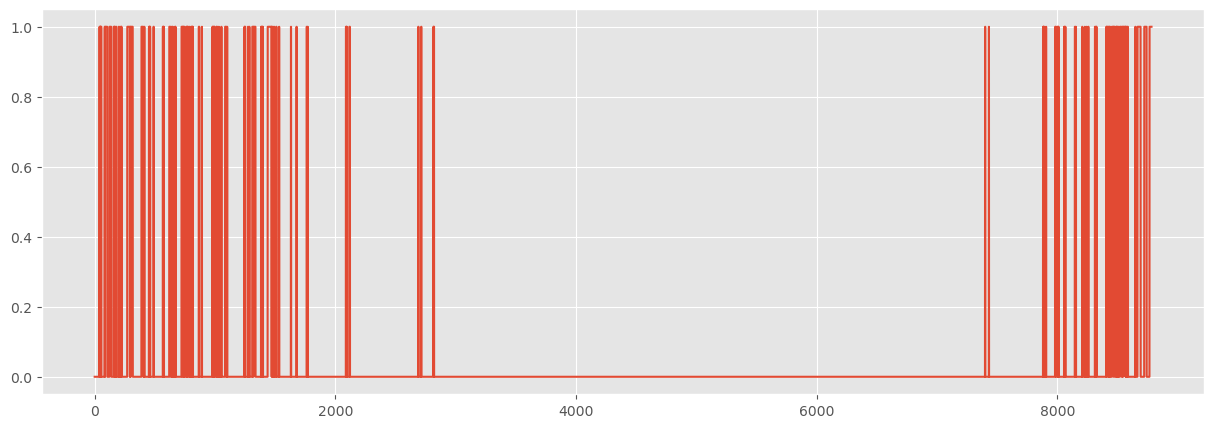

In [5]:
# More useful!
is_snowing=is_snowing.cast(pl.Float32)
snp.lineplot(is_snowing)

# 6.2 Use resampling to find the snowiest month

If we wanted the median temperature each month, we could use the `groupby_dynamic()` method like this:

Date/Time,Temp (C)
datetime[μs],f64
2012-01-01 00:00:00,-7.05
2012-02-01 00:00:00,-4.1
2012-03-01 00:00:00,2.6
2012-04-01 00:00:00,6.3
2012-05-01 00:00:00,16.05
2012-06-01 00:00:00,19.6
2012-07-01 00:00:00,22.9
2012-08-01 00:00:00,22.2
2012-09-01 00:00:00,16.1


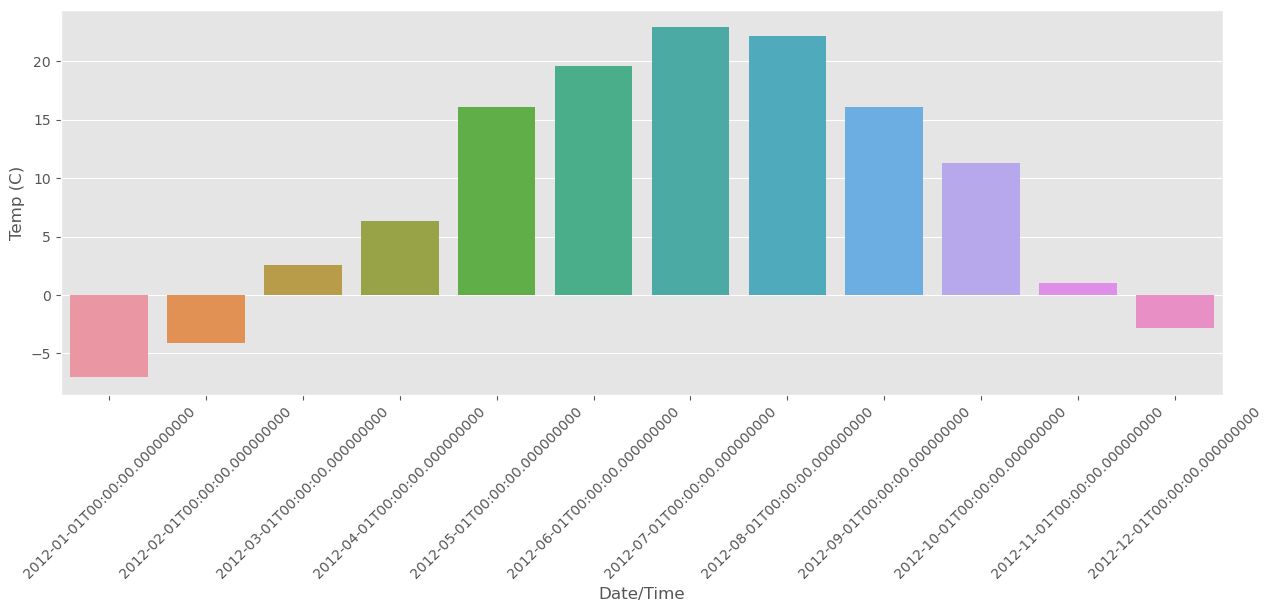

In [6]:
if not weather_2012['Date/Time'].is_sorted():
    weather_2012 = weather_2012.sort('Date/Time')

temp_by_month = weather_2012.set_sorted('Date/Time').groupby_dynamic(
    'Date/Time',
    every='1mo'
).agg(pl.col('Temp (C)').median())
plt.xticks(rotation=45)
display(temp_by_month)
snp.barplot(temp_by_month, x='Date/Time', y='Temp (C)')

Unsurprisingly, July and August are the warmest.

So we can think of snowiness as being a bunch of 1s and 0s instead of `True`s and `False`s:

In [7]:
is_snowing.cast(pl.Float32)[:10]

Weather
f32
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


and then use `groupby_dynamic` to find the percentage of time it was snowing each month

In [8]:
snow_by_month = weather_2012.set_sorted('Date/Time').groupby_dynamic(
    'Date/Time',
    every='1mo'
).agg(
    is_snowing=pl.col('Weather').str.contains('Snow').cast(pl.Float32).mean()
)
snow_by_month

Date/Time,is_snowing
datetime[μs],f32
2012-01-01 00:00:00,0.240591
2012-02-01 00:00:00,0.162356
2012-03-01 00:00:00,0.087366
2012-04-01 00:00:00,0.015278
2012-05-01 00:00:00,0.0
2012-06-01 00:00:00,0.0
2012-07-01 00:00:00,0.0
2012-08-01 00:00:00,0.0
2012-09-01 00:00:00,0.0


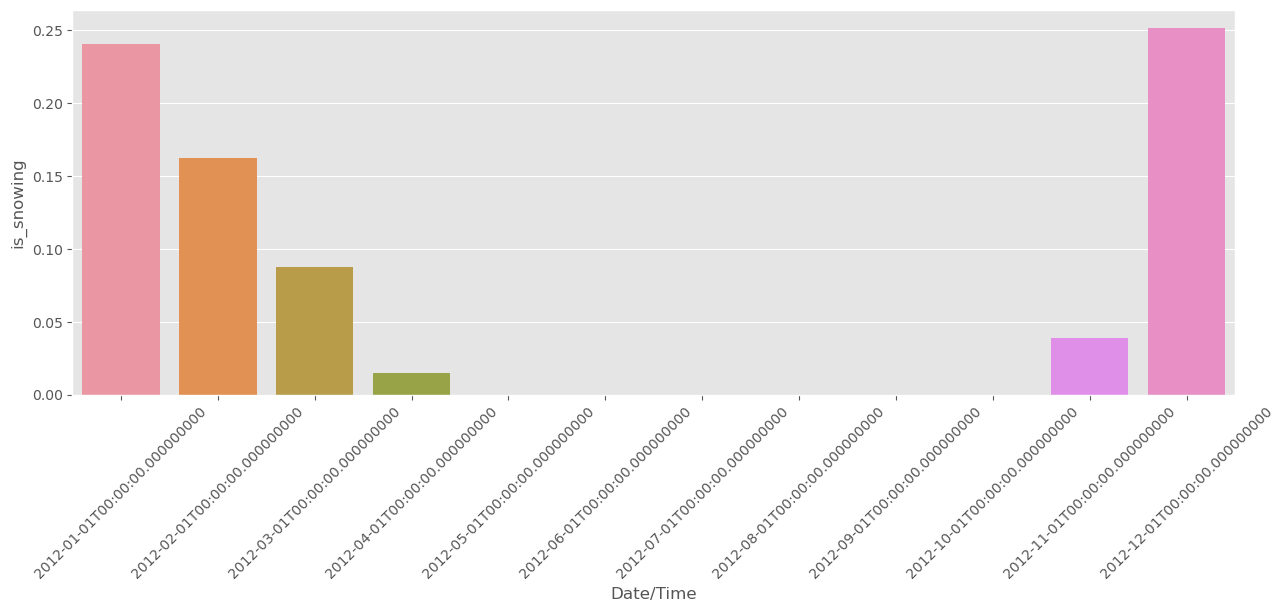

In [9]:
plt.xticks(rotation=45)
snp.barplot(snow_by_month, x='Date/Time', y='is_snowing')

So now we know! In 2012, December was the snowiest month. Also, this graph suggests something that I feel -- it starts snowing pretty abruptly in November, and then tapers off slowly and takes a long time to stop, with the last snow usually being in April or May.

# 6.3 Plotting temperature and snowiness stats together

We can also combine these two statistics (temperature, and snowiness) into one dataframe and plot them together:

In [10]:
months_list = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
months_dict = dict(enumerate(months_list, 1))
by_month = weather_2012.set_sorted('Date/Time').groupby_dynamic(
    'Date/Time',
    every='1mo'
).agg(
    pl.col('Temp (C)').median(),
    pl.col('Weather').str.contains('Snow').cast(pl.Float32).mean().alias('is_snowing'),
).with_columns(
    pl.col('Date/Time').dt.month().map_dict(months_dict).alias('Date'),
)
display(by_month)

Date/Time,Temp (C),is_snowing,Date
datetime[μs],f64,f32,str
2012-01-01 00:00:00,-7.05,0.240591,"""Jan"""
2012-02-01 00:00:00,-4.1,0.162356,"""Feb"""
2012-03-01 00:00:00,2.6,0.087366,"""Mar"""
2012-04-01 00:00:00,6.3,0.015278,"""Apr"""
2012-05-01 00:00:00,16.05,0.0,"""May"""
2012-06-01 00:00:00,19.6,0.0,"""Jun"""
2012-07-01 00:00:00,22.9,0.0,"""Jul"""
2012-08-01 00:00:00,22.2,0.0,"""Aug"""
2012-09-01 00:00:00,16.1,0.0,"""Sep"""


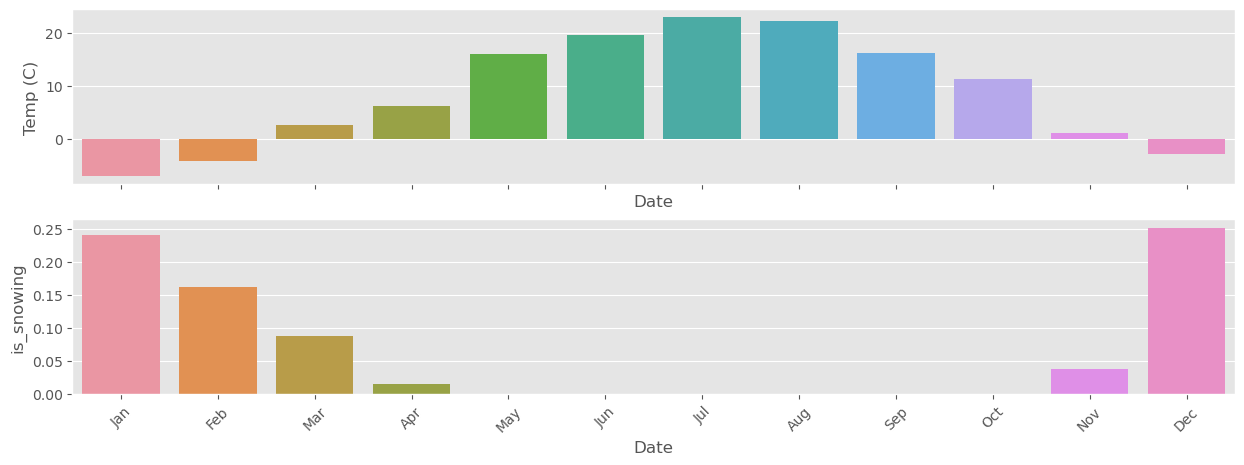

In [11]:
fig, ax = plt.subplots(2, sharex=True)
plt.xticks(rotation=45)
snp.barplot(by_month, x='Date', y='Temp (C)', ax=ax[0])
snp.barplot(by_month, x='Date', y='is_snowing', ax=ax[1])

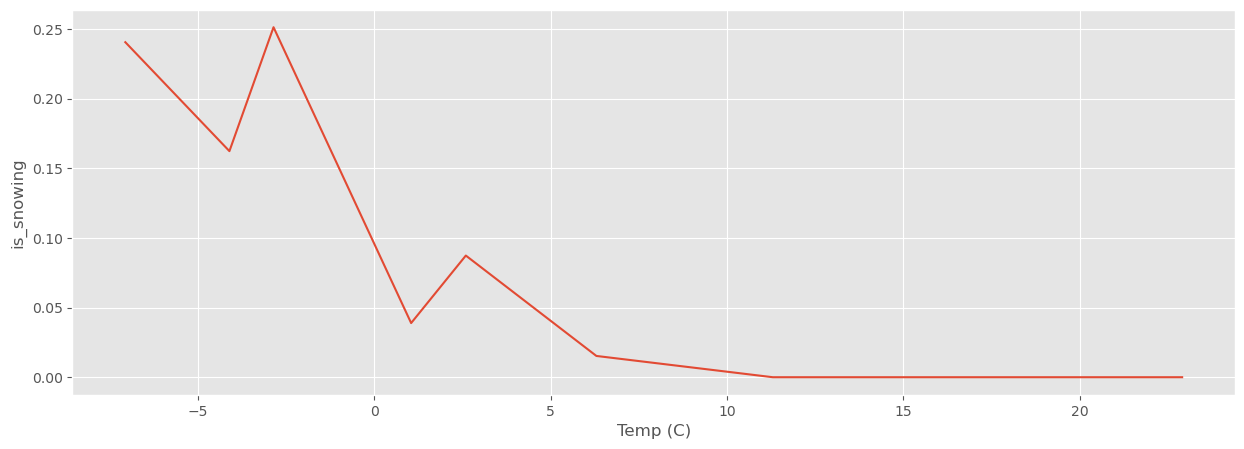

In [12]:
snp.lineplot(by_month, x='Temp (C)', y='is_snowing')